In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
batch_size = 64
n_bins = 2 ** 8

train_dataset = dsets.MNIST(
    root='./MNIST/', 
    train=True, 
    transform=transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        lambda x: x# / n_bins - 0.5 + torch.zeros_like(x).uniform_(0, 1. / n_bins)
    ]),
    download=True
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

In [3]:
class WeirdConv(nn.Module): 
    def __init__(self, in_, out):
        super().__init__()
        self.conv = nn.Conv2d(in_, out, 3, padding = 1)
        self.logfactor = nn.Parameter(torch.zeros((1, out, 1, 1)))
        
    def forward(self, input_):
        out = self.conv(input_)
        out *= torch.exp(self.logfactor)
        return out

In [4]:
class ZeroBiasInitConv(nn.Module): 
    def __init__(self, in_, out, kernel_size, actnorm, padding = 0):
        super().__init__()
        self.conv = nn.Conv2d(in_, out, kernel_size, padding = padding, bias = False)
        self.actnorm = actnorm
        
    def forward(self, input_):
        out = self.conv(input_)
        out, _ = self.actnorm(out)
        return out

In [5]:
class ActNorm(nn.Module):
    def __init__(self, h, w, c):
        super().__init__()
        self.shape = (h, w, c)
        self.initialized = False
        self.weights = nn.Parameter(torch.Tensor(c))
        self.bias = nn.Parameter(torch.Tensor(c))
        
    def forward(self, inp, logdet = 0):
        if not self.initialized:
            c = self.shape[-1]
            self.weights.data = torch.log(1/inp.transpose(0, 1).contiguous().view(c, -1).std(1))
            self.bias.data = -(inp * self.weights[..., None, None]).transpose(0, 1).contiguous().view(c, -1).mean(1)
            self.initialized = True
        
        return (inp + self.bias[..., None, None]) * torch.exp(self.weights[..., None, None]), logdet + self.shape[0] * self.shape[1] * torch.sum(torch.abs(self.weights))
    
    def reverse(self, out):
        return out / torch.exp(self.weights[..., None, None]) - self.bias[..., None, None]

class InvertibleConv(nn.Module):
    def __init__(self, h, w, c):
        super().__init__()
        self.shape = (h, w, c)
        self.weight = nn.Parameter(torch.from_numpy(np.linalg.qr(np.random.randn(c, c))[0]).float())
                                    
    def forward(self, inp, logdet):
        return torch.einsum("abcd,eb->aecd", (inp, self.weight)), logdet + self.shape[0] * self.shape[1] * torch.slogdet(self.weight)[1]

    def reverse(self, out):
        return torch.einsum("abcd,eb->aecd", (out, torch.inverse(self.weight)))

class AffineCoupling(nn.Module):
    def __init__(self, h, w, c):
        super().__init__()
        self.NN = nn.Sequential(
            ZeroBiasInitConv(c//2, 128, 3, ActNorm(h, w, 128), padding=1),
            nn.ReLU(),
            ZeroBiasInitConv(128, 128, 1, ActNorm(h, w, 128)),
            nn.ReLU(),
            WeirdConv(128, c)
        )
        
    def forward(self, inp, logdet):        
        x_a, x_b = torch.chunk(inp, 2, dim=1)
        pred = self.NN(x_b)
        log_s = pred[:, ::2]
        t = pred[:, 1::2]
        s = torch.sigmoid(log_s + 2)
        y_a = s * (x_a + t)
        return torch.cat([y_a, x_b], dim = 1), logdet + torch.sum(torch.log(s))
    
    def reverse(self, out):
        y_a, y_b = torch.chunk(out, 2, dim=1)
        pred = self.NN(y_b)
        log_s = pred[:, ::2]
        t = pred[:, 1::2]
        s = torch.sigmoid(log_s + 2)
        x_a = y_a / s - t
        return torch.cat([x_a, y_b], dim = 1)
    
class Flow(nn.Module):
    def __init__(self, K, h, w, c):
        super().__init__()
        self.k = K
        self.actnorms = nn.ModuleList(ActNorm(h, w, c) for i in range(K))
        self.invconvs = nn.ModuleList(InvertibleConv(h, w, c) for i in range(K))
        self.couplings = nn.ModuleList(AffineCoupling(h, w, c) for i in range(K))
        
    def forward(self, inp, logdet, z):        
        for i in range(self.k):
            inp, logdet = self.actnorms[i](inp, logdet)
            inp, logdet = self.invconvs[i](inp, logdet)
            inp, logdet = self.couplings[i](inp, logdet)
        
        return inp, logdet, z
    
    def reverse(self, inp, z):
        for i in range(self.k)[::-1]:
            inp = self.couplings[i].reverse(inp)
            inp = self.invconvs[i].reverse(inp)
            inp = self.actnorms[i].reverse(inp)

        return inp, z

In [6]:
def pixel_unshuffle(input_, block_size=2):
    b, c, h, w = input_.shape

    assert h % block_size == 0 and w % block_size == 0,\
        f"Shape must be divisible by block_size, got {input_.shape}"

    oc = c * block_size * block_size;
    oh = h // block_size;
    ow = w // block_size;

    input_reshaped = input_.view(b, c, oh, block_size, ow, block_size)
    return input_reshaped.permute(0, 1, 3, 5, 2, 4).reshape(b, oc, oh, ow)
    
class Squeeze(nn.Module):
    def __init__(self, block_size=2):
        super().__init__()
        self.block_size = block_size 

    def forward(self, input_, logdet, z):
        return pixel_unshuffle(input_, self.block_size), logdet, z
    
    def reverse(self, input_, z):
        return F.pixel_shuffle(input_, self.block_size), z

In [7]:
class Split(nn.Module):
    def forward(self, input_, logdet, z):
        out = input_[:, ::2]
        zi = input_[:, 1::2]

        return out, logdet, z + [zi]
    
    def reverse(self, input_, z):
        out = torch.zeros_like(torch.cat([input_, z[-1]], 1))
        out[:, ::2] = input_
        out[:, 1::2] = z[-1]
        
        return out, z[:-1]

In [8]:
class LogLikelihood(nn.Module): 
    def __init__(self, size):
        super().__init__()
        self.size = size
        self.norm = torch.distributions.MultivariateNormal(torch.zeros(size).to(device), torch.eye(size).to(device))

    def forward(self, input_, logdet, z):
        batch = input_.shape[0]
        comb_z = torch.cat([z_.contiguous().view(batch, -1) for z_ in z + [input_]], 1)

        return None, (logdet + torch.sum(self.norm.log_prob(comb_z))) / batch, z + [input_]
    
    def reverse(self, input_, z):
        return z[-1], z[:-1]

In [9]:
class GlowModel(nn.Module):
    def __init__(self, h, w, c, K, L):
        super().__init__()
        
        self.layers = nn.ModuleList()
        
        for i in range(1, L):
            self.layers.append(Squeeze())
            self.layers.append(Flow(K, h//(2**i), w//(2**i), c*2**(i+1)))
            self.layers.append(Split())

        self.layers.append(Squeeze())
        self.layers.append(Flow(K, h//(2**L), w//(2**L), c*2**(L+1)))
        self.layers.append(LogLikelihood(h*w*c))
        
    def forward(self, input_, logdet, z):
        for layer in self.layers:
            input_, logdet, z = layer(input_, logdet, z)

        return input_, logdet, z
    
    def reverse(self, input_, z):
        for layer in self.layers[::-1]:
            input_, z = layer.reverse(input_, z)

        return input_, z

In [10]:
from tqdm import tqdm as tqdm

def train_epoch(model, optimizer, batchsize=32):
    loss_log, acc_log = [], []
    model.train()
    batch_iter = tqdm(train_loader)
    for x_batch, _ in batch_iter:
        data = x_batch.to(device)
        optimizer.zero_grad()
        out, logdet, z = model(data, 0, [])
        
        loss = -logdet + np.log(n_bins) * np.prod(x_batch.shape[1:])
        loss.backward()
        torch.nn.utils.clip_grad_value_(model.parameters(), 5)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 100)
        optimizer.step()
        loss = loss.item()
        batch_iter.set_postfix(loss=loss)
        loss_log.append(loss)
    return loss_log

def plot_history(train_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()

    plt.show()

def interpolate(ind_1, ind_2, p):
    img = train_dataset[ind_1][0]
    out, logdet, z = model.forward(img[None, ...].to(device), 0, [])
    img2 = train_dataset[ind_2][0]
    out2, logdet2, z2 = model.forward(img2[None, ...].to(device), 0, [])
    diffs = [z2[i] - z[i] for i in range(len(z))]
    fig = plt.figure(figsize=(24, 8))
    for i in range(p + 1):
        z_i = [z[j] + diffs[j] * i / p for j in range(len(z))]
        res = model.reverse(None, z_i)
        fig.add_subplot(1, p + 1, i + 1)
        plt.imshow(res[0].squeeze().detach().cpu().numpy())
        plt.axis('off')
    plt.show()
    
def train(model, opt, n_epochs):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    for epoch in range(n_epochs):
        train_loss = train_epoch(model, opt, batchsize=batch_size)
        train_log.extend(train_loss)

        clear_output()
        plot_history(train_log)
        interpolate(np.random.randint(0, len(train_dataset)), np.random.randint(0, len(train_dataset)), 5)

In [ ]:
model = GlowModel(32, 32, 1, 10, 2).to(device)
train(model, optim.Adam(model.parameters()), 100)

 94%|█████████▎| 879/938 [03:08<00:12,  4.70it/s, loss=6.35e+3]

In [12]:
def postprocess(x):
    return np.clip(np.floor((x + 0.5) * n_bins), 0, 255)

In [13]:
img = train_dataset[41][0]
out, logdet, z = model.forward(img[None, ...].to(device), 0, [])

In [14]:
img2 = train_dataset[7643][0]
out2, logdet2, z2 = model.forward(img2[None, ...].to(device), 0, [])

In [15]:
norm = torch.distributions.MultivariateNormal(torch.zeros(1024).to(device), torch.eye(1024).to(device))

In [16]:
norm.log_prob(torch.zeros_like(torch.cat([z_.contiguous().view(1, -1) for z_ in z], 1)))

tensor([-940.9930], device='cuda:0')

In [17]:
norm.log_prob(torch.cat([z_.contiguous().view(1, -1) for z_ in z], 1))

tensor([-943.3279], device='cuda:0', grad_fn=<ThSubBackward>)

In [18]:
a = torch.cat([z_.contiguous().view(1, -1) for z_ in z], 1)

In [19]:
norm = torch.distributions.MultivariateNormal(torch.zeros(1024).to(device), torch.eye(1024).to(device))
b = []
for i in range(1000):
    a = norm.sample()
    b.append(torch.norm(a))

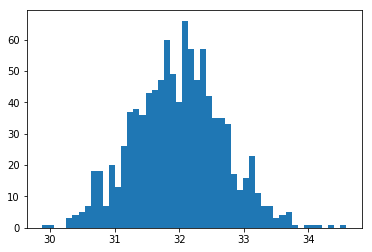

In [20]:
plt.hist(b, bins = 50)
plt.show()

In [21]:
b = []
for i in range(1000):
    img = train_dataset[i][0]
    out, logdet, z = model.forward(img[None, ...].to(device), 0, [])
    b.append(torch.norm(torch.cat([z_.contiguous().view(1, -1) for z_ in z], 1)).detach().cpu().numpy())

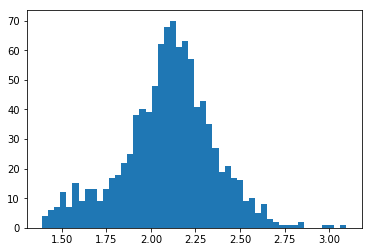

In [22]:
plt.hist(b, bins = 50)
plt.show()

In [ ]:
b = []
for i in range(1000):
    img = train_dataset[i][0]
    img = torch.rand_like(img)
    out, logdet, z = model.forward(img[None, ...].to(device), 0, [])
    b.append(torch.norm(torch.cat([z_.contiguous().view(1, -1) for z_ in z], 1)).detach().cpu().numpy())
plt.hist(b, bins = 50)
plt.show()

In [23]:
diffs = [z2[i] - z[i] for i in range(len(z))]

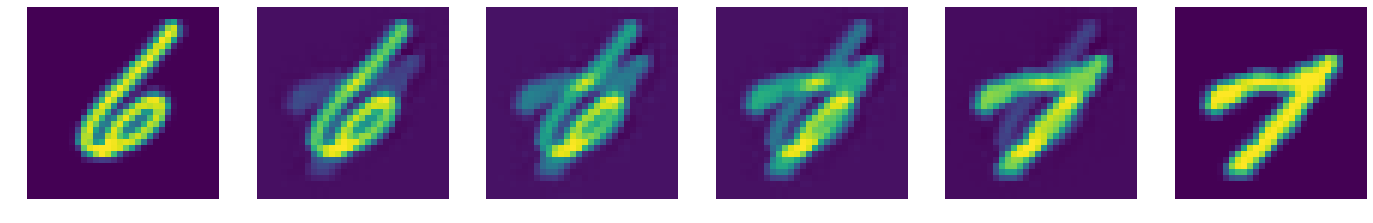

In [24]:
p = 5
fig = plt.figure(figsize=(24, 8))
for i in range(p + 1):
    z_i = [z[j] + diffs[j] * i / p for j in range(len(z))]
    res = model.reverse(None, z_i)
    fig.add_subplot(1, p + 1, i + 1)
    plt.imshow(res[0].squeeze().detach().cpu().numpy())
    plt.axis('off')
plt.show()

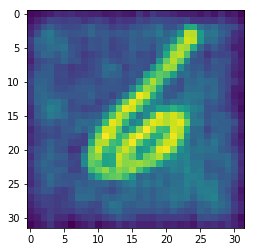

In [25]:
new_z = [z_ + torch.zeros_like(z_).uniform_(0, 1./10) for z_ in z]
res = model.reverse(None, new_z)
plt.imshow(res[0].squeeze().detach().cpu().numpy())

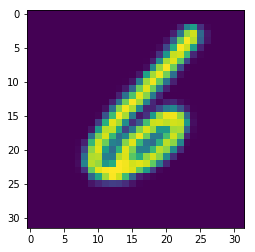

In [26]:
#z[-1][-1, -1, -1, -1] += 0.1
res = model.reverse(None, z)
plt.imshow(res[0].squeeze().detach().cpu().numpy())